In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

In [12]:
# Read dataset
df = pd.read_csv("student_habits_performance.csv")

# Drop kolom student_id (identifier yang tidak perlu)
df = df.drop(columns=['student_id'])

1. Basic DataFrame Info
Shape of the data (rows, columns):
(1000, 15)

Data types of columns:
age                                int64
gender                            object
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                     object
attendance_percentage            float64
sleep_hours                      float64
diet_quality                      object
exercise_frequency                 int64
parental_education_level          object
internet_quality                  object
mental_health_rating               int64
extracurricular_participation     object
exam_score                       float64
dtype: object


2. Summary Statistics for Numerical Columns
             age  study_hours_per_day  social_media_hours  netflix_hours  \
count  1000.0000           1000.00000         1000.000000    1000.000000   
mean     20.4980              3.55010            2.505500       1.819700   
std

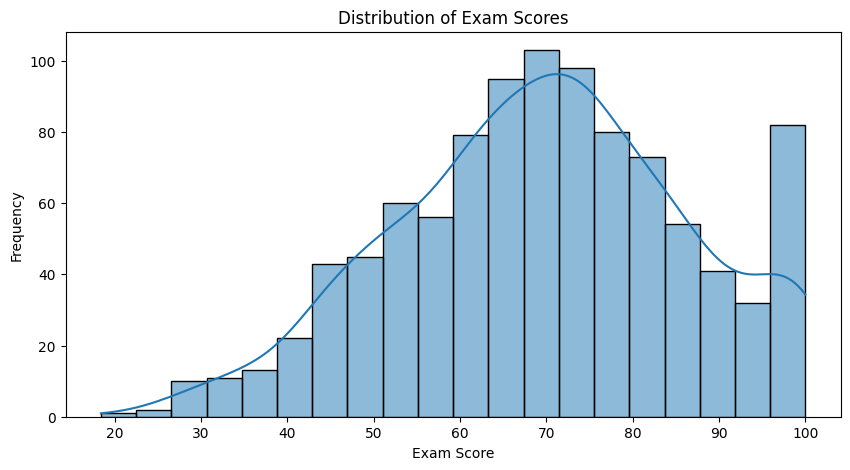



4. Distribution & Skewness of Numerical Features


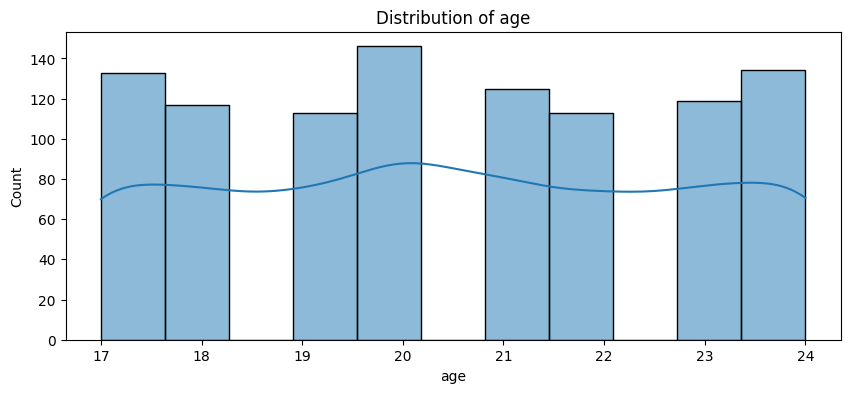

Column: age, Skewness: 0.01, Kurtosis: -1.22


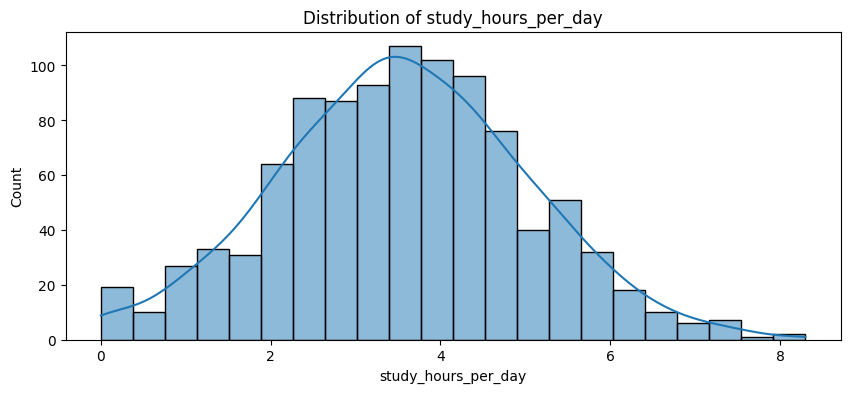

Column: study_hours_per_day, Skewness: 0.05, Kurtosis: -0.06


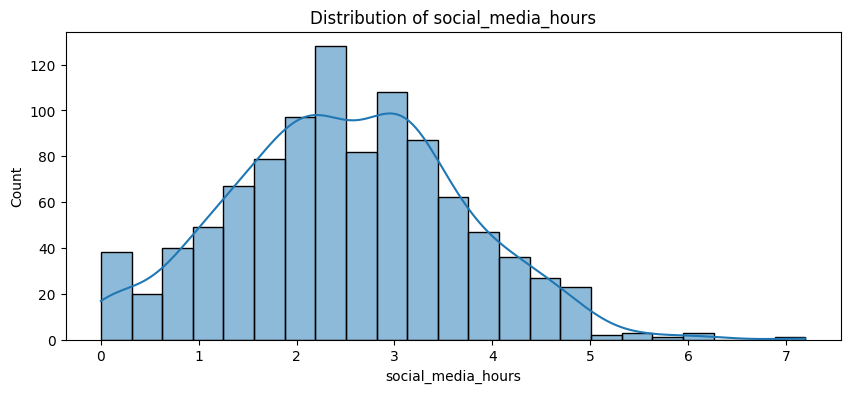

Column: social_media_hours, Skewness: 0.12, Kurtosis: -0.09


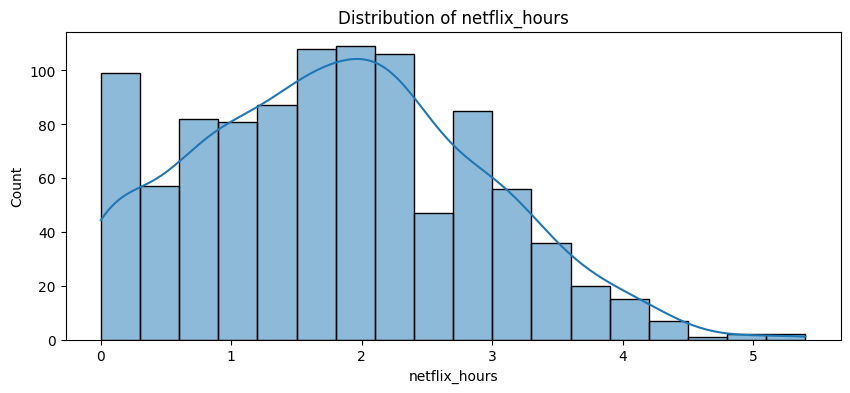

Column: netflix_hours, Skewness: 0.24, Kurtosis: -0.43


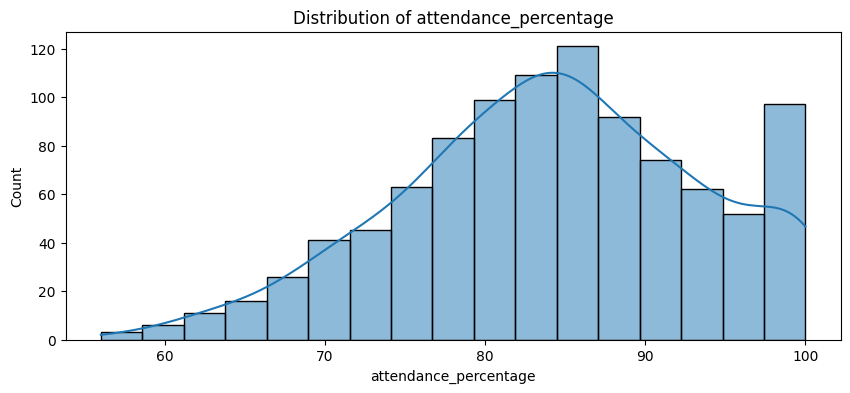

Column: attendance_percentage, Skewness: -0.24, Kurtosis: -0.39


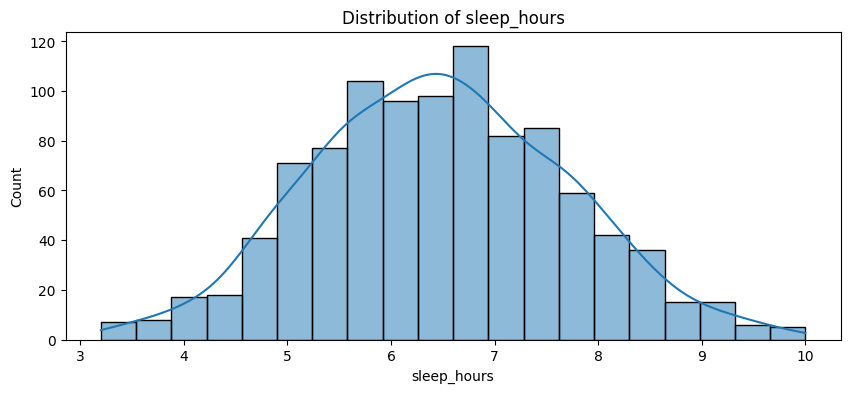

Column: sleep_hours, Skewness: 0.09, Kurtosis: -0.21


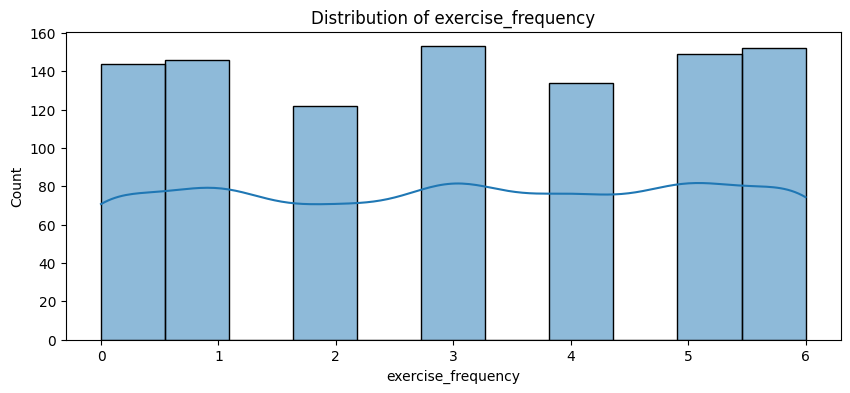

Column: exercise_frequency, Skewness: -0.03, Kurtosis: -1.28


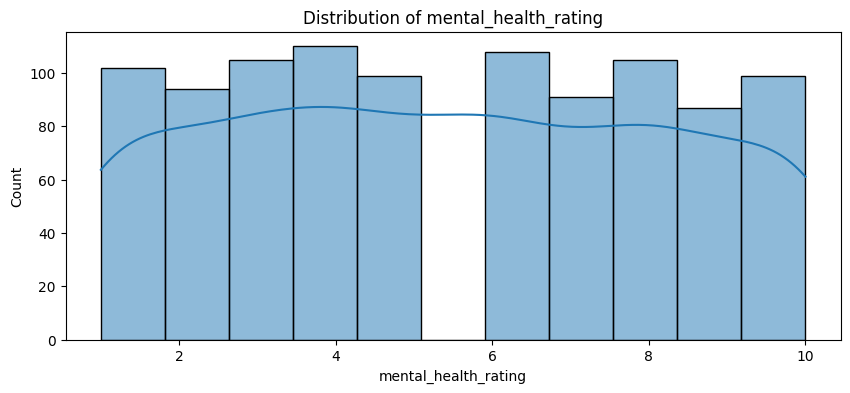

Column: mental_health_rating, Skewness: 0.04, Kurtosis: -1.19


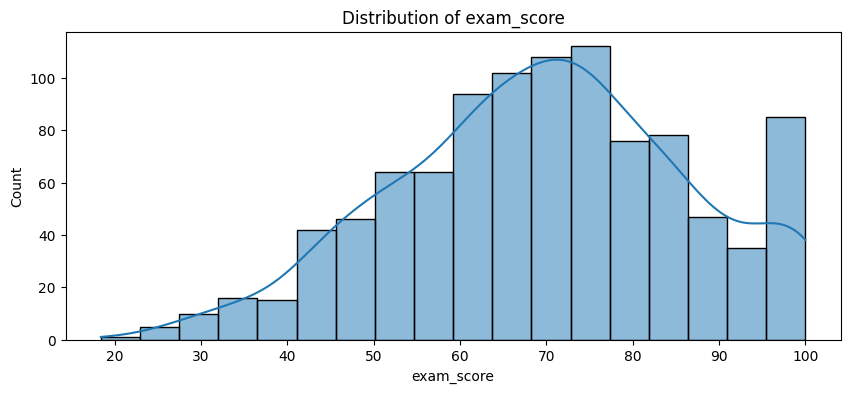

Column: exam_score, Skewness: -0.16, Kurtosis: -0.42


5. Outlier Analysis


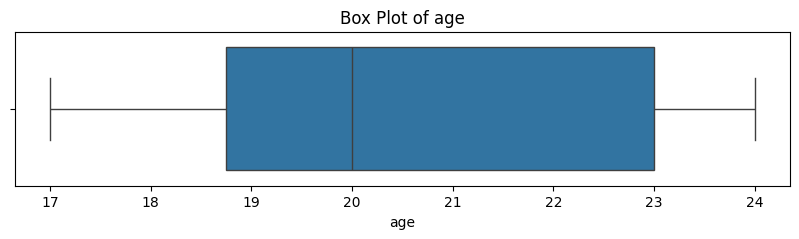

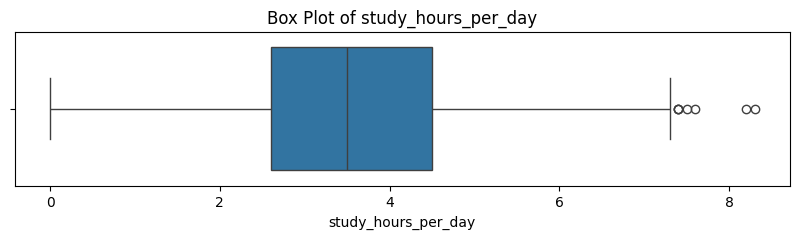

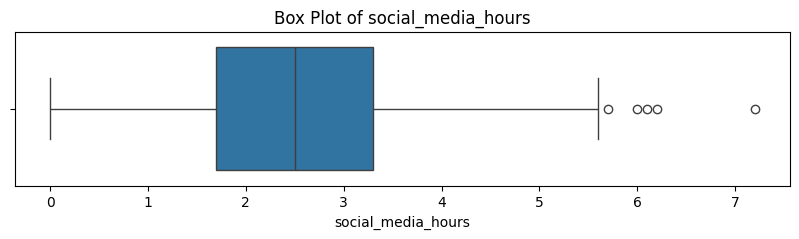

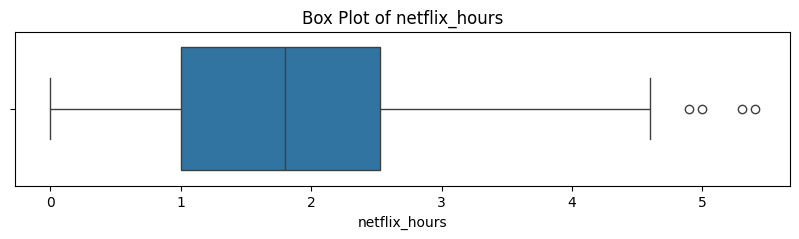

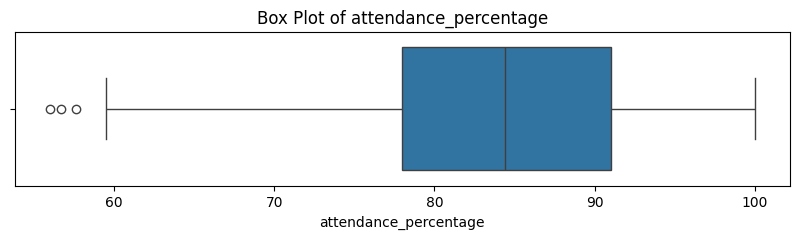

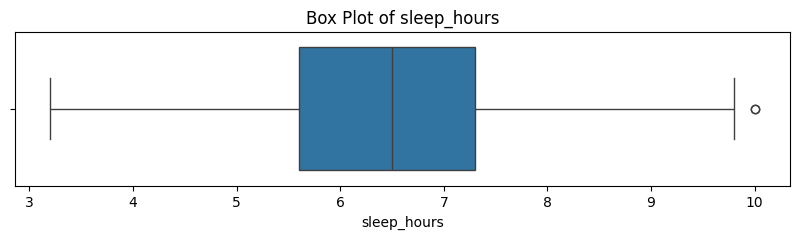

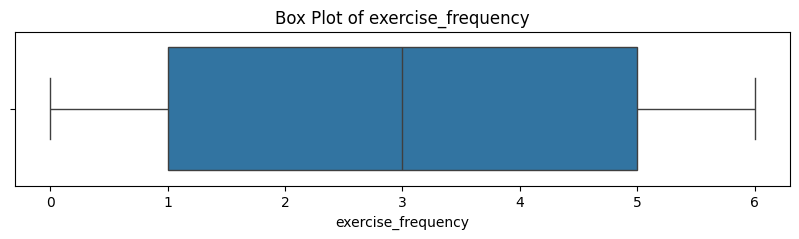

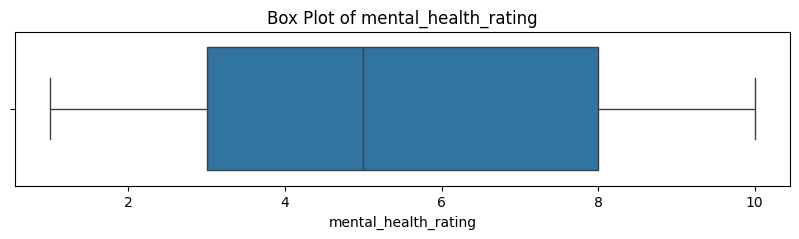

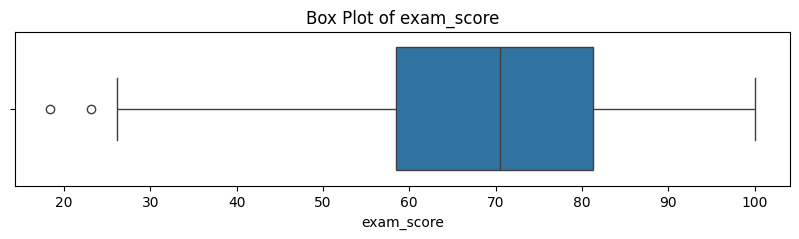

In [13]:
print("1. Basic DataFrame Info")
print("Shape of the data (rows, columns):")
print(df.shape)
print("\nData types of columns:")
print(df.dtypes)
print("\n")

print("2. Summary Statistics for Numerical Columns")
print(df.describe())
print("\n")

print("3. Target Variable: 'exam_score'")
plt.figure(figsize=(10, 5))
sns.histplot(df['exam_score'], kde=True, bins=20)
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.show()
print("\n")

print("4. Distribution & Skewness of Numerical Features")
numerical_cols = df.select_dtypes(include=np.number).columns
for column in numerical_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()
    print(f"Column: {column}, Skewness: {df[column].skew():.2f}, Kurtosis: {df[column].kurt():.2f}")
print("\n")

print("5. Outlier Analysis")
for column in numerical_cols:
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.show()
print("\n")

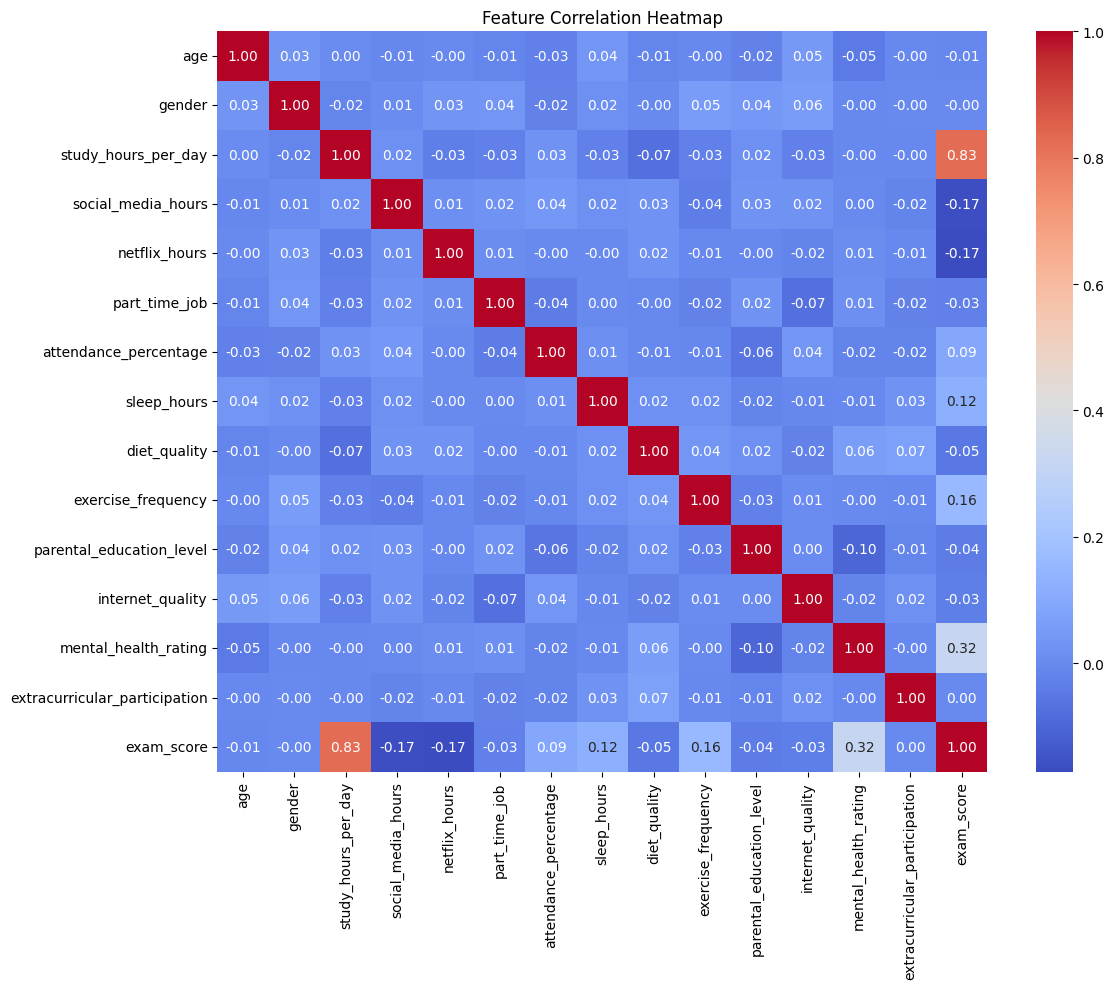

In [14]:
# Handle missing values (tidak perlu, hanya sebagai best practice)
missing_percentage = df.isna().sum() / len(df) * 100

for key, value in missing_percentage.items() : 
	if(value > 50.0) : 
		df = df.drop(columns = [key], axis = 1)

for column in df.columns : 
	if(df[column].isna().any()) : 
		if(df[column].dtype != "object") : 
			df[column] = df[column].fillna(df[column].median())
		else : 
			df[column] = df[column].fillna(df[column].mode()[0])		

# Encoding
categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
for col, le in label_encoders.items():
    df[col] = le.transform(df[col])

# Pisahkan target dari fitur
X = df.drop(columns=['exam_score'])
y = df['exam_score']

# EDA dengan heatmap berisi korelasi antar fitur
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [15]:
# Split data menjadi training & testing (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Dictionary untuk menyimpan result
results = {}

# Linear Regression (Tidak ada parameter untuk tuning)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
results['LinearRegression'] = {
    'R2 Score': r2_score(y_test, y_pred_lr),
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr))
}


# Tuning untuk SVR
print("\nSVR")
svr_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
svr_grid = GridSearchCV(SVR(), svr_param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
svr_grid.fit(X_train, y_train)
y_pred_svr = svr_grid.predict(X_test)
results['SVR'] = {
    'R2 Score': r2_score(y_test, y_pred_svr),
    'MAE': mean_absolute_error(y_test, y_pred_svr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_svr))
}
print(f"Best SVR Params: {svr_grid.best_params_}")


# Tuning untuk Gradient Boosting Regressor
print("\nGradient Boosting Regressor")
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
gb_grid.fit(X_train, y_train)
y_pred_gb = gb_grid.predict(X_test)
results['GradientBoostingRegressor'] = {
    'R2 Score': r2_score(y_test, y_pred_gb),
    'MAE': mean_absolute_error(y_test, y_pred_gb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gb))
}
print(f"Best Gradient Boosting Params: {gb_grid.best_params_}")


# Tuning untuk Random Forest Regressor
print("\nRandom Forest Regressor")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
y_pred_rf = rf_grid.predict(X_test)
results['RandomForestRegressor'] = {
    'R2 Score': r2_score(y_test, y_pred_rf),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf))
}
print(f"Best Random Forest Params: {rf_grid.best_params_}")


# Hasil akhir
final_results_df = pd.DataFrame(results).T.sort_values(by='R2 Score', ascending=False)
print("\nKomparasi antara model dengan parameter terbaik")
print(final_results_df)


SVR
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVR Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Gradient Boosting Regressor
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Gradient Boosting Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}

Random Forest Regressor
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Random Forest Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Komparasi antara model dengan parameter terbaik
                           R2 Score       MAE      RMSE
LinearRegression           0.896666  4.172476  5.147596
SVR                        0.893031  4.254383  5.237363
GradientBoostingRegressor  0.874537  4.706736  5.672064
RandomForestRegressor      0.848031  5.000385  6.242545


Top 7 selected features:
['study_hours_per_day', 'mental_health_rating', 'social_media_hours', 'exercise_frequency', 'sleep_hours', 'netflix_hours', 'attendance_percentage']


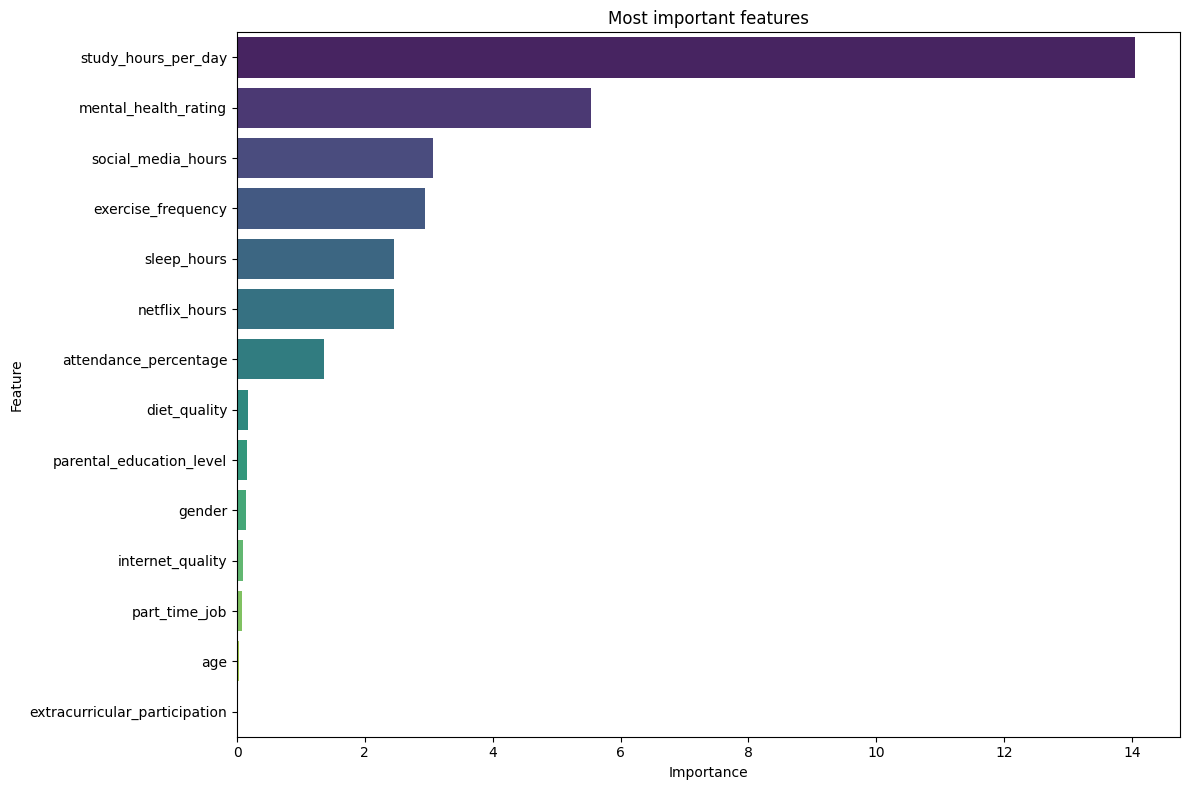

In [16]:
# RF Regressor untuk semua fitur
model_for_selection = LinearRegression()
model_for_selection.fit(X_scaled, y)

# Cari importance dari feature
importances = np.abs(model_for_selection.coef_)
feature_names = X.columns

# DataFrame untuk visualisasi
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top 8 dari feature paling penting
top_n_features = 7
top_features = feature_importance_df['Feature'].head(top_n_features).tolist()

print(f"Top {top_n_features} selected features:")
print(top_features)

# Plot importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis', hue='Feature', legend=False)
plt.title('Most important features')
plt.tight_layout()
plt.show()


In [20]:
# Buat DataFrame hanya dengan top feature yang tadi dipilih
X_selected = X[top_features]

# Buat scaler baru dengan top feature yang tadi dipilih
scaler_final = StandardScaler()
X_selected_scaled = pd.DataFrame(scaler_final.fit_transform(X_selected), columns=top_features)

# Split data menjadi training & testing (80:20)
X_train_sel, X_test_sel, y_train, y_test = train_test_split(
    X_selected_scaled, y, test_size=0.2, random_state=42
)

# Train model Linear Regression untuk feature yang tadi dipilih
final_model = LinearRegression()
final_model.fit(X_train_sel, y_train)

# Predict
y_pred_sel = final_model.predict(X_test_sel)

# Evaluasi final model
final_model_r2 = r2_score(y_test, y_pred_sel)
final_model_mae = mean_absolute_error(y_test, y_pred_sel)
final_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_sel))

# Buat dataframe untuk hasil evaluasi dan print
final_model_results = {
    'Model': ['Final Linear Regression (Top 7 Features)'],
    'R2 Score': [final_model_r2],
    'MAE': [final_model_mae],
    'RMSE': [final_model_rmse]
}
final_model_results_df = pd.DataFrame(final_model_results)
print(final_model_results_df)

                                      Model  R2 Score       MAE      RMSE
0  Final Linear Regression (Top 7 Features)   0.89958  4.113914  5.074502


In [ ]:
# Save model, scaler, dan label_encoder
joblib.dump(final_model, "model.pkl")
joblib.dump(scaler_final, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']